In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import datetime
from sklearn.model_selection import GridSearchCV
import joblib
from xgboost import XGBClassifier

In [30]:
pub = pd.read_csv('data/public_data.csv')
submit_template = pd.read_csv('data/minta_beadando_rand.csv')

In [31]:
def train_test_split_function(x):
    if x == 4:
        return "submit"
    elif x == 3:
        return "test"
    else:
        return "train"

In [32]:
pub['train_test_validation'] = pub['day_in_period'].apply(train_test_split_function)


In [33]:
pub['ke_hupx_ratio'] = pub['ke'] / pub['hupx']
for lag in range(1, 5):
    pub[f'ke_lag_{lag}'] = pub.groupby('periodID')['ke'].shift(lag)

In [34]:
input_variables = [
    'hour', 'minute', 'holyday', 'weekday', 'ke', 'hupx', 'afrr_fel', 'afrr_le',
    'mfrr_fel', 'mfrr_le', 'afrr', 'solar_becsult_dayahead',
    'rendszerterheles_terv', 'ke_hupx_ratio', 'ke_lag_1', 'ke_lag_2', 'ke_lag_3', 'ke_lag_4'
]


In [35]:
train_df = pub[pub['train_test_validation'] == 'train'].dropna()
test_df = pub[pub['train_test_validation'] == 'test'].dropna()
submit_df = pub[pub['train_test_validation'] == 'submit']

In [36]:
X_train = train_df[input_variables]
y_train = train_df['target_flag']

X_test = test_df[input_variables]
y_test = test_df['target_flag']

In [37]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [55]:
rf_params = {
    'n_estimators': [30, 300],
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42, max_depth=5, min_samples_split = 10, min_samples_leaf = 5,), rf_params, scoring='roc_auc', cv=3)
rf_grid.fit(X_train_smote, y_train_smote)
rf_model = rf_grid.best_estimator_

In [56]:
gb_params = {
    'n_estimators': [30, 300],
}

gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42, learning_rate=0.005, max_depth=2, min_samples_split=10, min_samples_leaf=5, ), gb_params, scoring='roc_auc', cv=3)
gb_grid.fit(X_train_smote, y_train_smote)
gb_model = gb_grid.best_estimator_

In [194]:
rf_model = RandomForestClassifier(max_depth=1, min_samples_leaf=15, min_samples_split=20, max_features='log2',
                       n_estimators=300, random_state=42)
gb_model = GradientBoostingClassifier(learning_rate=0.005, max_depth=1, min_samples_leaf=30,
                           min_samples_split=20, n_estimators=50,
                           random_state=42)
xgb_model = XGBClassifier(learning_rate = 0.0001, n_estimators = 30, gamma = 0.2, max_depth=4,
                          min_child_weight= 5, subsample=0.8, max_leaves= 96)

In [195]:
print(rf_model)
print(gb_model)
print(xgb_model)

RandomForestClassifier(max_depth=1, max_features='log2', min_samples_leaf=15,
                       min_samples_split=20, n_estimators=300, random_state=42)
GradientBoostingClassifier(learning_rate=0.005, max_depth=1,
                           min_samples_leaf=30, min_samples_split=20,
                           n_estimators=50, random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.9, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=96,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy

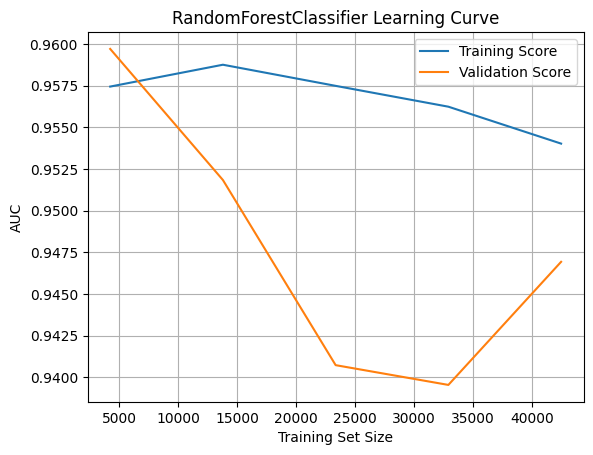

In [185]:
# Plotting to determine wether there is overfitting or underfitting
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('AUC')
plt.title('RandomForestClassifier Learning Curve')
plt.legend()
plt.grid()
plt.show()

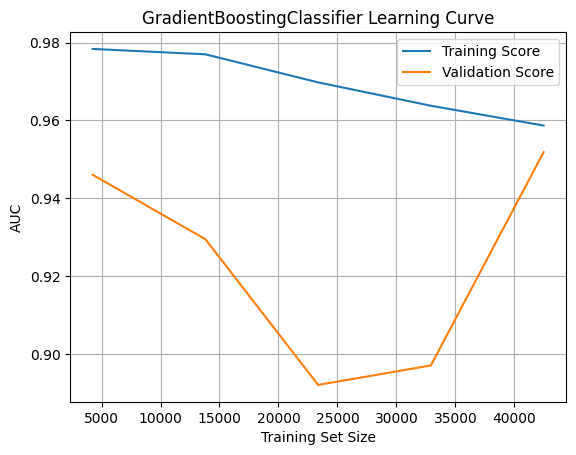

In [186]:
train_sizes, train_scores, test_scores = learning_curve(
    gb_model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('AUC')
plt.title('GradientBoostingClassifier Learning Curve')
plt.legend()
plt.grid()
plt.show()

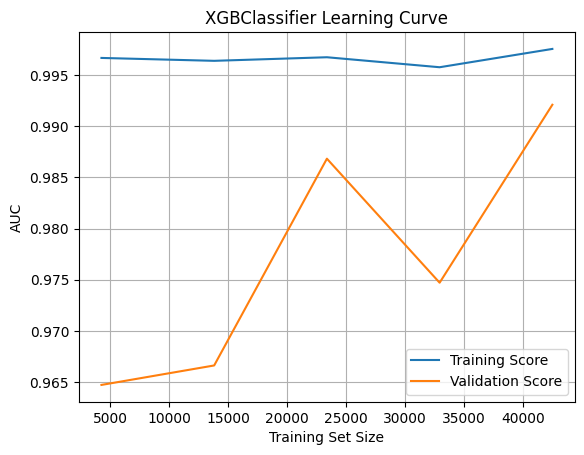

In [196]:
train_sizes, train_scores, test_scores = learning_curve(
    xgb_model, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1, error_score='raise')

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training Score')
plt.plot(train_sizes, test_mean, label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('AUC')
plt.title('XGBClassifier Learning Curve')
plt.legend()
plt.grid()
plt.show()

In [188]:
gb_model.fit(X_train_smote, y_train_smote)
rf_model.fit(X_train_smote, y_train_smote)
xgb_model.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.9, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=96,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

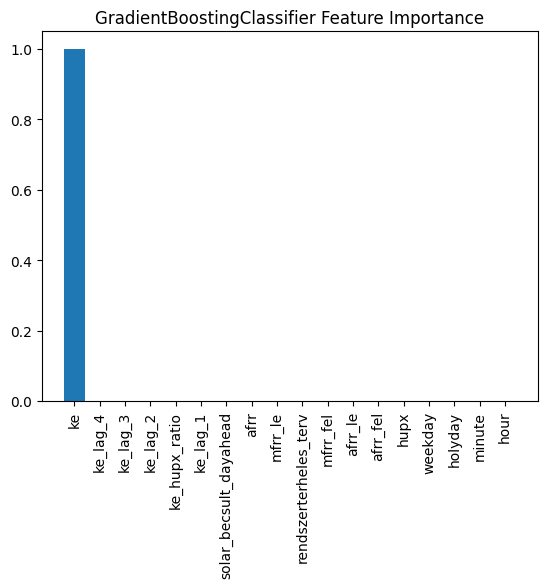

In [137]:
importances = gb_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [input_variables[i] for i in indices], rotation=90)
plt.title('GradientBoostingClassifier Feature Importance')
plt.show()

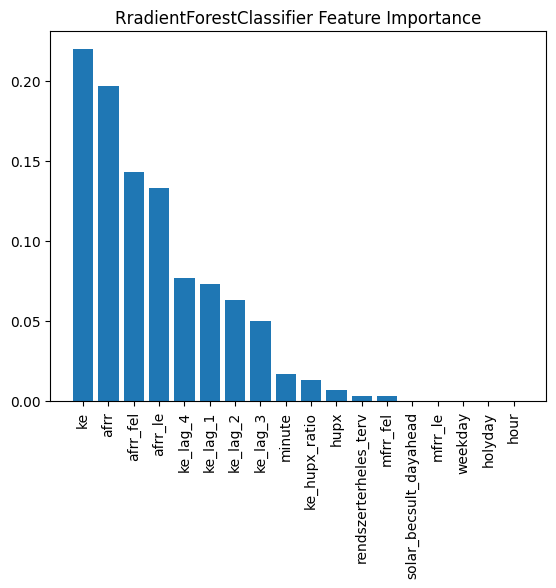

In [138]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [input_variables[i] for i in indices], rotation=90)
plt.title('RradientForestClassifier Feature Importance')
plt.show()

In [189]:
rf_predictions = rf_model.predict_proba(X_test)[:, 1]
gb_predictions = gb_model.predict_proba(X_test)[:, 1]
xgb_predictions = xgb_model.predict_proba(X_test)[:, 1]

rf_auc = roc_auc_score(y_test, rf_predictions)
gb_auc = roc_auc_score(y_test, gb_predictions)
xgb_auc = roc_auc_score(y_test, xgb_predictions)

print(f"Random Forest AUC: {rf_auc}")
print(f"Gradient Boosting AUC: {gb_auc}")
print(f"XGB AUC: {xgb_auc}")

Random Forest AUC: 0.9497785220612347
Gradient Boosting AUC: 0.9479565666384776
XGB AUC: 0.9963167610437429


In [191]:
ensemble_predictions = (rf_predictions + xgb_predictions) / 2
ensemble_auc = roc_auc_score(y_test, ensemble_predictions)
print(f"Ensemble AUC: {ensemble_auc}")

Ensemble AUC: 0.9561447374769647


In [192]:
submit_df['prediction'] = ensemble_predictions
submit_df = submit_df[['rowID', 'prediction']]

In [193]:
current_time = datetime.datetime.now()
time_string = current_time.strftime("%Y%m%d_%H%M%S")
filename = f"prediction_datas/ensemble_{time_string}.csv"
submit_df.to_csv(filename, index=False)

print(f"Submission saved to {filename}")

Submission saved to prediction_datas/ensemble_20241210_040355.csv
